In [36]:
#Q1
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt; 
from sklearn.tree import DecisionTreeClassifier; from sklearn.model_selection import train_test_split; from sklearn import metrics; from sklearn.tree import export_graphviz;
from sklearn.externals.six import StringIO; from IPython.display import Image;
import pydotplus; from sklearn.model_selection import cross_val_score; from sklearn.ensemble import RandomForestClassifier;

#load train and test
combined = [pd.read_csv('../Titanic/train.csv'), pd.read_csv('../Titanic/test.csv')]
positions = range(2)

#counts the features with missing values
def count_nulls(dataset):
    return list(filter(lambda x: next(iter(x.values())), 
      map(lambda f: {f: len(dataset.loc[dataset[f].isnull()])}, dataset.columns)))

def print_null_count():
    for x in positions:
        null_features_counts = count_nulls(combined[x])
        print(str(null_features_counts))

print_null_count()
#From HW1, I decided to drop the cabin feature since it had too many null values (687 in train and 327 in test). I am dropping PassengerId and Name as well since they are meaningless for the training
#For more info check Q15 of: https://github.com/lumalav/CAP5610/blob/master/HW1/HW1.ipynb
for x in positions:
    for y in ['Cabin', 'PassengerId', 'Name']:
        combined[x] = combined[x].drop(y, 1)

[{'Age': 177}, {'Cabin': 687}, {'Embarked': 2}]
[{'Age': 86}, {'Fare': 1}, {'Cabin': 327}]


In [37]:

#Q1 Continuation
#converting Sex feature into numerical values 
#For more info check Q16 of: https://github.com/lumalav/CAP5610/blob/master/HW1/HW1.ipynb
for x in positions:
    combined[x] = combined[x].replace({'Sex': 'male'}, {'Sex': 0})
    combined[x] = combined[x].replace({'Sex': 'female'}, {'Sex': 1})

print(combined[0]['Sex'].head())

0    0
1    1
2    1
3    1
4    0
Name: Sex, dtype: int64


In [38]:
#Q1 Continuation
#Since there are 177 missing values for the Age feature train and 86 in test, I will fill these values with random numbers between mean and the std of each set
#For more info check Q17 of: https://github.com/lumalav/CAP5610/blob/master/HW1/HW1.ipynb

def apply_uniform_fill(dataset, column):
    std = dataset[column].std()
    mean = dataset[column].mean()
    dataset[column] = dataset[column].apply(lambda x: np.random.uniform(mean, std, 1)[0] if np.isnan(x) else x)

#test.csv is missing a Fare value. same technique is applied
for x in positions:
    apply_uniform_fill(combined[x], 'Age')
    if(x == 1):
        apply_uniform_fill(combined[x], 'Fare')


In [39]:
#Q1 Continuation
#Since there are two missing values for the Embarked feature, I will fill these values with the most common occurrence from the entire set
#For more info check Q18 of: https://github.com/lumalav/CAP5610/blob/master/HW1/HW1.ipynb
embarked = combined[0].pivot_table(index=['Embarked'], aggfunc ='size').to_frame().sort_values([0], ascending=False).iloc[0]

print('Most common port of embarkation: ' + embarked.name + ', with: ' + str(embarked.values[0]) + ' occurrences')
combined[0]['Embarked'] = combined[0]['Embarked'].apply(lambda x: embarked.name if pd.isnull(x) else x)

#no more null values in the datasets
print_null_count()

Most common port of embarkation: S, with: 644 occurrences
[]
[]


In [40]:
#Q1 Continuation
#To improve performance, continuous data like Fare and Age will be set into buckets
#For more info check Q20 of: https://github.com/lumalav/CAP5610/blob/master/HW1/HW1.ipynb
fare_buckets = [-0.001,7.91,14.4542,31.0,512.3292]
age_buckets = [0,15,25,50,75,80]
for x in positions:
    combined[x]['Fare'] = pd.cut(combined[x]['Fare'], bins=fare_buckets, labels=[1,2,3,4])
    combined[x]['Age'] = pd.cut(combined[x]['Age'], bins=age_buckets, labels=[1,2,3,4,5])

Age 1: 0-15
Age 2: 15-25
Age 3: 25-50
Age 4: 50-75
Age 5: 75-80


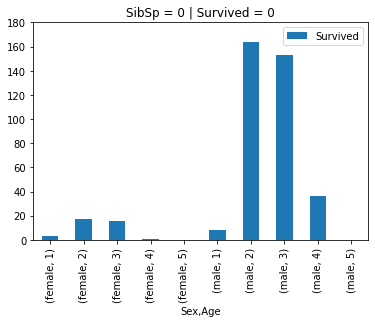

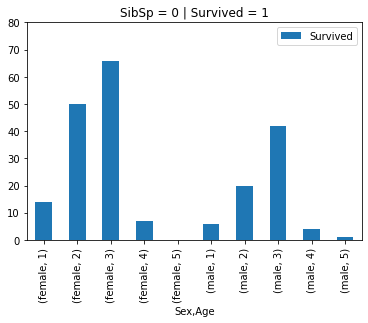

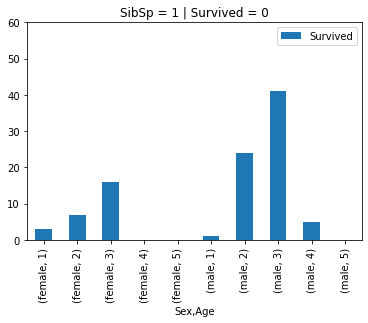

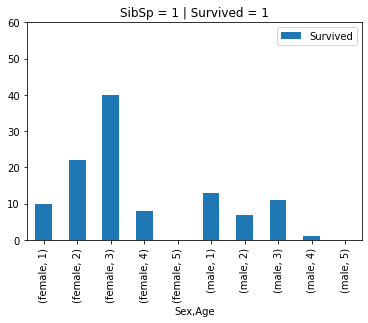

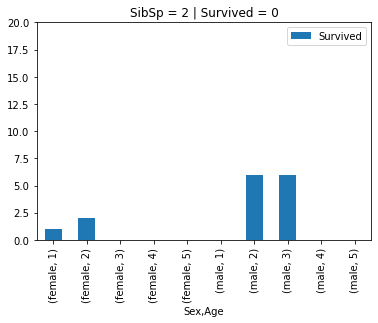

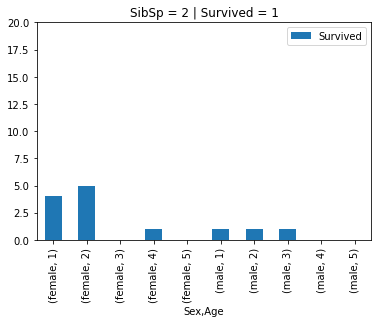

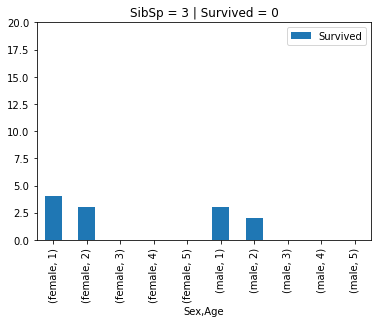

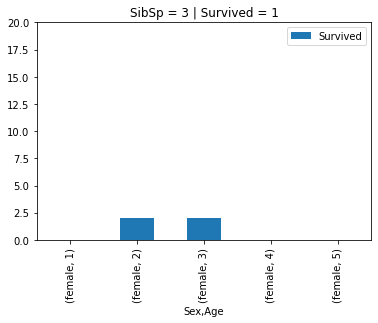

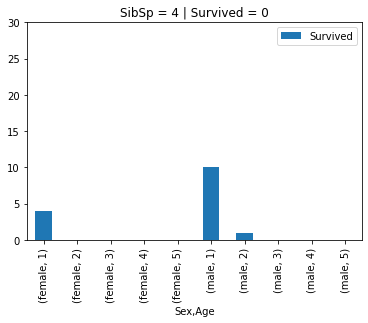

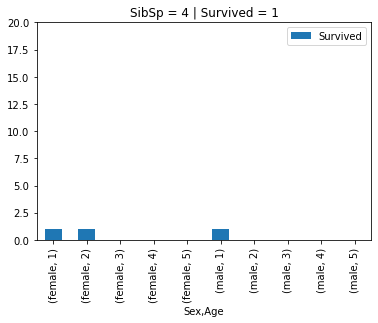

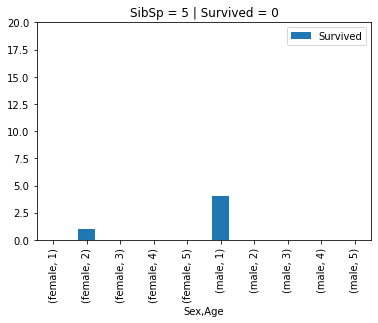

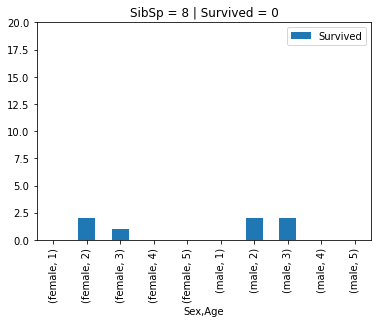

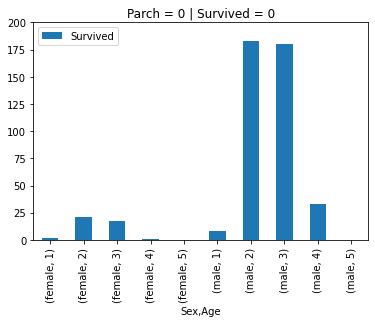

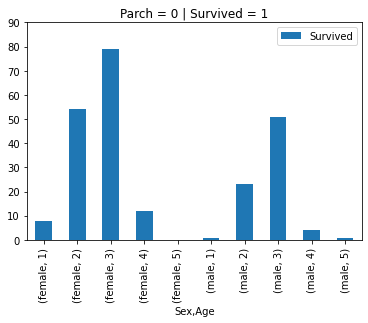

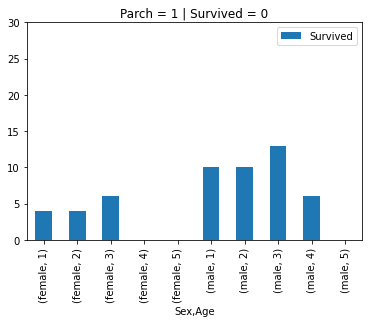

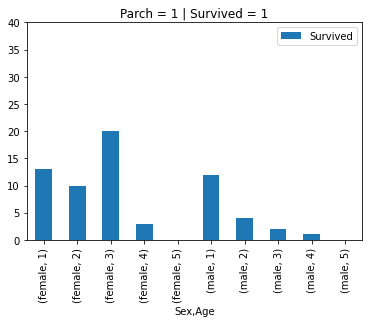

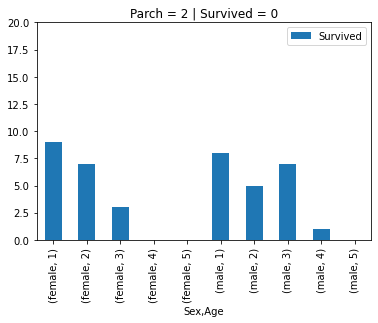

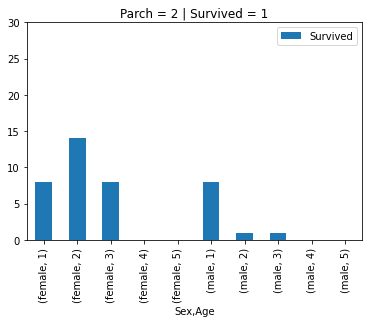

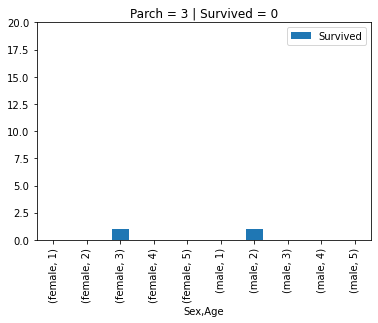

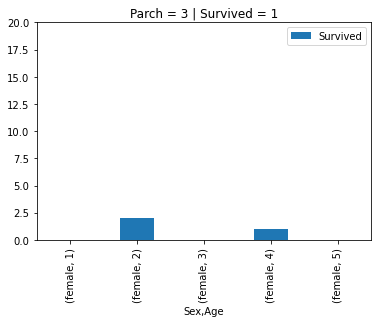

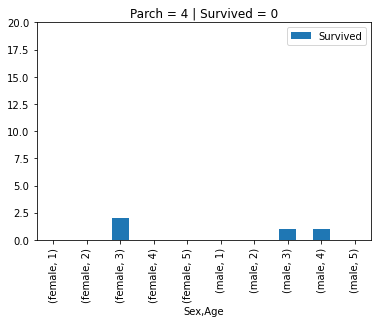

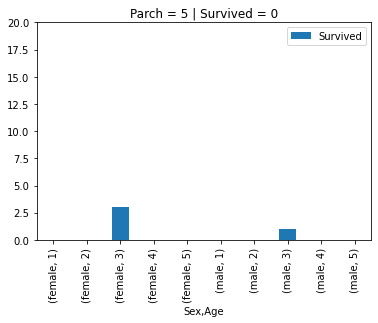

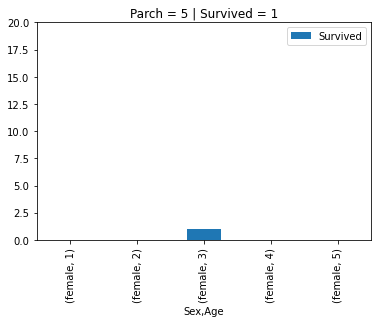

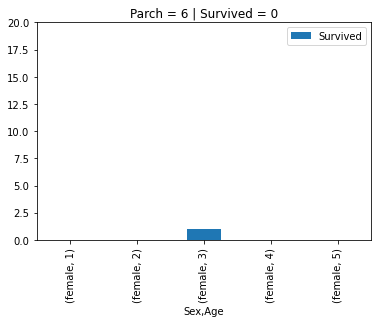

In [41]:
#Q2
#From HW1 we showed strong correlation between Survived-Age, Survived-Sex, Survived-Pclass, Survived-Embarked, and Survived-Ticket
#Regarding the SibSp and Parch features, these might be more useful if they were splitted into four columns:
#Siblings, Spouse, Parents, Children. Because even though we can display some nice charts when grouping by Age, Survived and Sex. For older people is difficult to see
#if they have their parents with them or their children or both at the same time. Likewise, the same problem occurs with the number of siblings and spouse. We are not really sure which is which so I'll be dropping these features as well
q2 = combined[0]
q2 = q2.replace({'Sex': 0}, {'Sex': 'male'})
q2 = q2.replace({'Sex': 1}, {'Sex': 'female'})
for x in ['Fare', 'Embarked', 'Pclass', 'Ticket']:
    q2 = q2.drop(x, 1)
for x in ['SibSp', 'Parch']:
    for g, group in q2.groupby([x, 'Survived']):
        result = group.drop('SibSp', 1).drop('Parch', 1).groupby(['Sex', 'Age']).count()
        yl = result['Survived'].max() + (20 - result['Survived'].max()%10)
        result.plot(kind='bar', title= x + ' = ' + str(g[0]) + ' | ' + 'Survived = ' + str(g[1]), ylim=(0,yl));

for x in positions:
    for y in ['SibSp', 'Parch']:
        combined[x] = combined[x].drop(y, 1)

print('Age 1: 0-15\nAge 2: 15-25\nAge 3: 25-50\nAge 4: 50-75\nAge 5: 75-80')

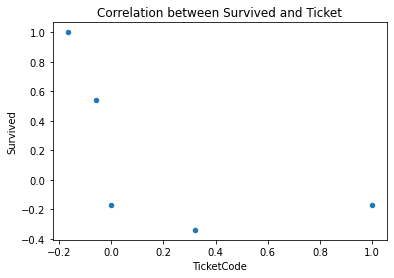

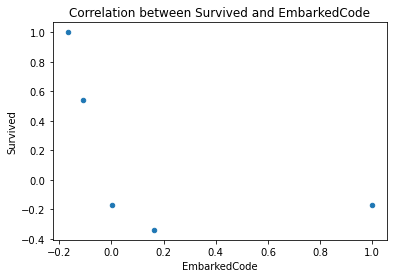

In [42]:
#Q2 Continuation

#For both sets, I applied a numerical value to the Ticket and Embarked Features to two new columns
def apply_conversion_to_values(column, new_column):
    codes = {}
    i = 0
    grouped_series = combined[0][column].append(combined[1][column])
    for g, _ in grouped_series.groupby(grouped_series):
        codes[g] = i
        i = i + 1
    for x in positions:
        combined[x][new_column] = combined[x][column].apply(lambda y: codes[y])
    return codes

ticket_codes = apply_conversion_to_values('Ticket', 'TicketCode')
#we do the same for the embarkation port
embarked_codes = apply_conversion_to_values('Embarked', 'EmbarkedCode')

#It seems there is a higher chance of survival on lower tickets codes and lower embarkation ports
corr = combined[0].corr()
corr.plot.scatter(x='TicketCode',y='Survived', title='Correlation between Survived and Ticket');
corr.plot.scatter(x='EmbarkedCode',y='Survived', title='Correlation between Survived and EmbarkedCode');

Decision Tree average five-fold cross validation accuracy: 0.8159312033142928
Accuracy using test data: 0.8229665071770335


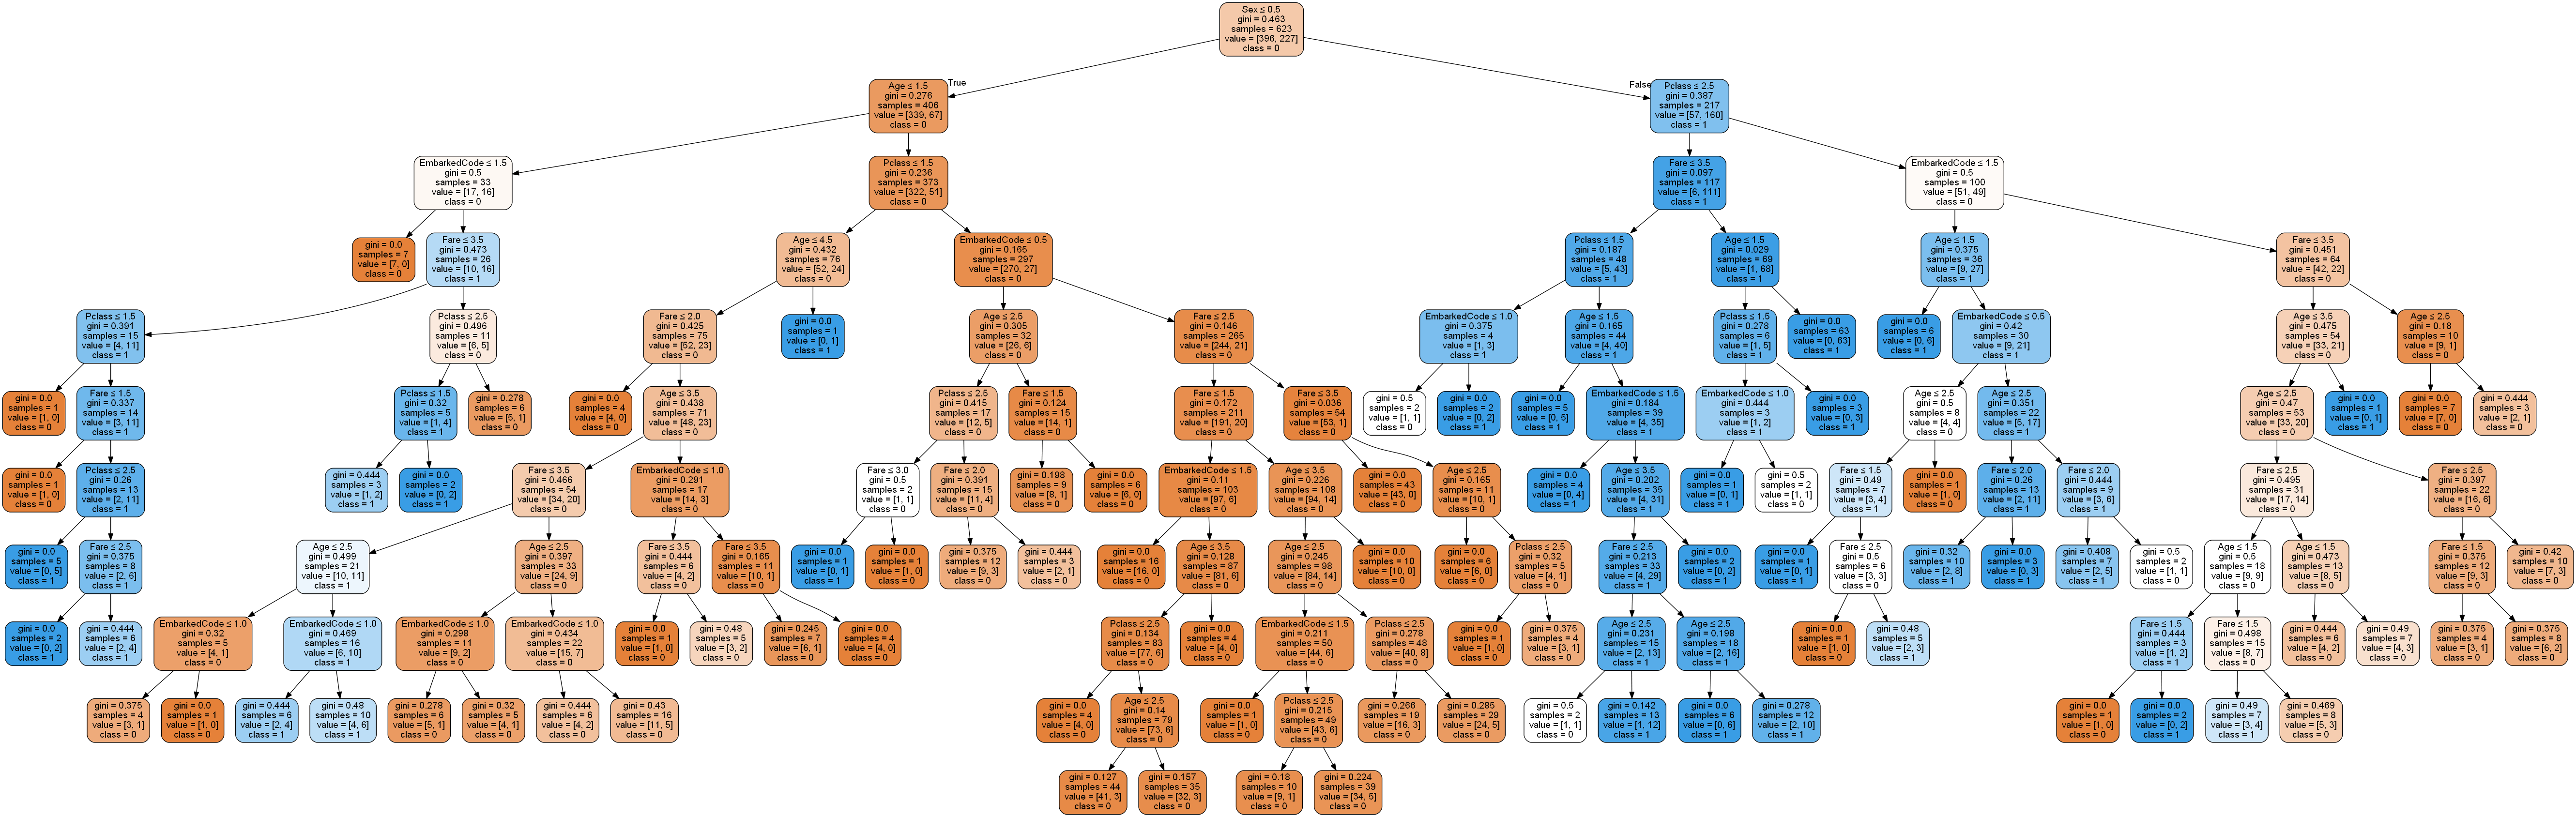

In [47]:
#Q3 and Q4
features = ['Sex', 'Age', 'Fare', 'Pclass', 'EmbarkedCode'] #TicketCode dropped
X = combined[0][features] #features
y = combined[0].Survived  #target
X_test = combined[1][features]
y_test = pd.read_csv('../Titanic/gender_submission.csv').Survived

X_train, _, y_train, _ = train_test_split(X, y, test_size=0.3, random_state=1)

def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1])) 

depth = []
for i in range(3,20):
    clf = DecisionTreeClassifier(max_depth=i)
    # Perform 5-fold cross validation 
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=5, n_jobs=4)
    depth.append((i,scores.mean()))

best_depth = Sort_Tuple(depth)[-1]

classifier = DecisionTreeClassifier(max_depth=best_depth[0])
classifier = classifier.fit(X_train,y_train)

# Model Accuracy, how often is the classifier correct
print('Decision Tree average five-fold cross validation accuracy:', best_depth[1])
print("Accuracy using test data:",metrics.accuracy_score(y_test, classifier.predict(X_test)))

dot_data = StringIO()
export_graphviz(classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names =features,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('DecisionTree.png')
Image(graph.create_png())

In [48]:
#Q5
estimators = []
for i in range(3,15):
    clf = RandomForestClassifier(n_estimators=i)
    # Perform 5-fold cross validation 
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=5, n_jobs=4)
    estimators.append((i,scores.mean()))

best_estimator = Sort_Tuple(estimators)[-1]

randomForestClassifier = RandomForestClassifier(n_estimators=best_estimator[0])
randomForestClassifier.fit(X_train,y_train)
print('Random forest average five-fold cross validation accuracy:', best_estimator[1])
print("Accuracy using test data:",metrics.accuracy_score(y_test, randomForestClassifier.predict(X_test)))

Random forest average five-fold cross validation accuracy: 0.8226602222082733
Accuracy using test data: 0.8421052631578947
